# Capstone Project 1: Exploring Netflix recomender system.
In this project, I explored the use of collaborative movie recomender system, using the Netflix Prize data set.
I made use of the ALternate least squares and Singular Value Decomposition methods.
More information about the data processing and exploratory data analysis i carried out can be found in ht efollowing links:

-)Data acquisition, processing and wrangling: 
https://github.com/masaver/springboard/tree/master/capstone1_explring_netlix's_movie_recomender_system/data%20acquisition%20and%20wrangling

-)Exploratory data analysis:
https://github.com/masaver/springboard/tree/master/capstone1_explring_netlix's_movie_recomender_system/exploratory%20data%20analysis

The complete report for this project can be found at:
https://github.com/masaver/springboard/tree/master/capstone1_explring_netlix's_movie_recomender_system/final%20report


# 0. Loading the libraries that will be needed for this analysis.

In [3]:
%matplotlib inline
%precision %.6f
%pylab inline

#The Alternate Least squares (ALS) method from the MLlib from  pyspark, 
# will be used for the collaborative filtering model.
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pyspark
from pyspark.mllib.recommendation import ALS

#Numpy, pandas and matplotlib are used for data manipulation and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#I also import the mean_squared_error function, which will be used for calculating the RMSE.
from sklearn.metrics import mean_squared_error

#Time is used for measuring the time required to train the ALS model
from time import time

#Image & display are used for displayaing a gif animation later.
from IPython.display import Image
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


# 1. Loading the requiered data.
***Trying to analyze the entire NetFlix prize data set on a single computer proved to be too computationally intensive. 
Instead, I opted to take a random sample ('ratings_subset_plus_biases.csv') of 1 million rating to work with.

In [2]:
# The following part loads the data frame containing the movies name, id, year of release, and genre information
df_movies = pd.read_csv('movies_plus_genre_info_2.csv')
df_movies.index.name = 'MovieID'
df_movies.index = np.arange(1, len(df_movies)+1)

#The followin line, load the ratings (subset) dataset
df_data = pd.read_csv('ratings_subset_plus_biases.csv')
df_data.head()

,User ID,Rating,Date,Movie ID,Year of Release,user_bias,movie_bias,year_bias,genre_bias
0,1789934,4,2002-02-12,9886,1999,0.394528,0.067970,-0.001312,0.023799
1,2400047,3,2005-11-02,12074,1965,0.394528,0.393205,0.212024,0.066932
2,1986551,1,2003-05-16,299,2001,-0.405472,0.084883,-0.052638,-0.059922
3,2000221,3,2005-10-21,4262,1999,-0.105472,-0.055885,-0.001312,-0.098143
4,849373,3,2005-09-27,17302,1991,-0.105472,0.194528,0.018199,-0.047243


The 'ratings_subset_plus_biases.csv' file also containes user, movie, year and genre specific rating biases, 
which were calculated previously. For example, the user-specific bias was calculated as the average user rating  minus
the average rating of the entire dataset. The other biases were calculated similarly.

For subsequent analysis, I also need to calculate this biases individually. 
For that, I grouped the data by user or movie ID. Then, I use custom defined functions, shown below, to determine each bias.

# 2. Seting up a Spark session & Loading Data.

In [3]:
# Here I'm setting up the spark context
conf = (pyspark.SparkConf()
         .setMaster("local")
         .setAppName("My app")
         .set("spark.executor.memory", "1g"))
sc = pyspark.SparkContext(conf = conf)
spark = SparkSession(sc)

In [4]:
#Here, I'm loading the ratings csv file and casting the apropiate data types
df_rdd = spark.read.csv("ratings_subset_plus_biases.csv", header = True)
X=df_rdd.select(df_rdd['User ID'],df_rdd['Movie ID'],df_rdd['Rating'].cast("float"),df_rdd['user_bias'].cast("float"),
               df_rdd['movie_bias'].cast("float"), df_rdd['year_bias'].cast("float"), df_rdd['genre_bias'].cast("float"))
ratings_rdd_2 = X.rdd
ratings_rdd_2.first()

Row(User ID=u'1789934', Movie ID=u'9886', Rating=4.0, user_bias=0.39452800154685974, movie_bias=0.06796973198652267, year_bias=-0.0013120227959007025, genre_bias=0.023799005895853043)

# 3. Using the Raw average as ratings predictor

Here, the predicted rating for a movie would be the average rating of the entire data set. I also considered the effect of different rating biases. To measure the error, I used the root mean squared error (RMSE).

In [5]:
meanRating = ratings_rdd_2.map(lambda x: x[2]).collect()
mean_rating = np.mean(meanRating)

#Raw average alone
aux = ratings_rdd_2.map(lambda x: ((mean_rating - x[2])**2)).collect()
baseRMSE = np.sqrt(np.mean(aux))

#Raw average + User-specific rating bias
aux = ratings_rdd_2.map(lambda x: ((mean_rating - x[2] + x[3])**2)).collect()
userBiasRMSE = np.sqrt(np.mean(aux))

#Raw average + Movie-specific rating bias
aux = ratings_rdd_2.map(lambda x: (np.nansum(mean_rating - x[2] + x[4]))**2).collect()
movieBiasRMSE = np.sqrt(np.mean(aux))

#Raw average + Year_of_release-specific rating bias
aux = ratings_rdd_2.map(lambda x: (np.nansum(mean_rating - x[2] + x[5]))**2).collect()
yearBiasRMSE = np.sqrt(np.mean(aux))

#Raw average + Genre-specific rating bias
aux = ratings_rdd_2.map(lambda x: (np.nansum(mean_rating - x[2] + x[6]))**2).collect()
genreBiasRMSE = np.sqrt(np.mean(aux))

#Raw average + User-specific + Movie-specific rating bias
aux = ratings_rdd_2.map(lambda x: ((mean_rating - x[2] + x[3] + x[4])**2)).collect()
usermovieBiasRMSE = np.sqrt(np.mean(aux))

#Raw average + all biases
aux = ratings_rdd_2.map(lambda x: ((mean_rating - x[2] + x[3] + x[4] + x[5] +x[6])**2)).collect()
allBiasRMSE = np.sqrt(np.mean(aux))

#As a measure of the accuracy of the predictions I used RMSE
print("The baseline RMSE is %.2f") % (baseRMSE) 
print("The RMSE with user bias is %.2f") % (userBiasRMSE) 
print("The RMSE with movie bias is %.2f") % (movieBiasRMSE) 
print("The RMSE with year of release bias is %.2f") % (yearBiasRMSE) 
print("The RMSE with genre bias is %.2f") % (genreBiasRMSE) 
print("The RMSE with user and movie bias is %.2f") % (usermovieBiasRMSE) 
print("The RMSE with all biases is %.2f") % (allBiasRMSE) 

The baseline RMSE is 1.09
The RMSE with user bias is 0.83
The RMSE with movie bias is 1.00
The RMSE with year of release bias is 1.08
The RMSE with genre bias is 1.08
The RMSE with user and movie bias is 0.80
The RMSE with all biases is 0.82


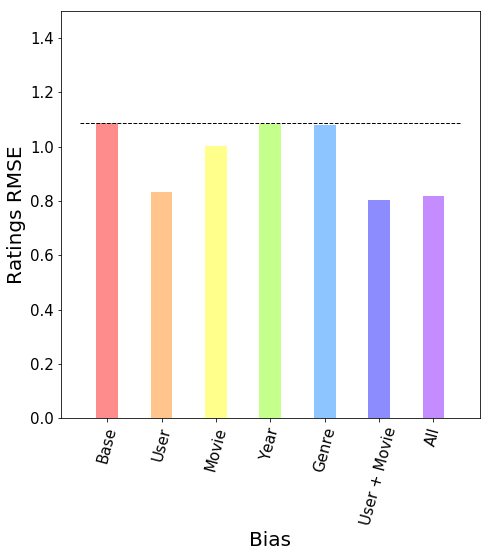

In [6]:
rmses = [baseRMSE,userBiasRMSE,movieBiasRMSE,yearBiasRMSE, genreBiasRMSE,usermovieBiasRMSE, allBiasRMSE]
x_pos = list(range(1,2*len(rmses),2))
color = ['#FF6666', '#FFB266', '#FFFF66','#B2FF66', '#66B2FF', '#6666FF', '#B266FF']
labels = ['Base', 'User', 'Movie', 'Year', 'Genre', 'User + Movie', 'All']

fig, ax = plt.subplots(figsize = (7.5, 7.5))

plt.plot([0,14],[baseRMSE]*2, linewidth = 1, color = 'k', linestyle = '--')
plt.bar(x_pos,
        # using the data from the mean_values
        rmses, 
        # aligned in the center
        align='center',
        # with color
        color = color,
        # transparency
        alpha=.75)

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
plt.ylim(0,1.5)
plt.xticks(rotation=75)
plt.xlabel('Bias', fontsize = 20)
plt.ylabel('Ratings RMSE', fontsize = 20)
ax.tick_params(labelsize=15)

plt.savefig('raw_avg RMSEs.png', bbox_inches="tight")


From the plot above we can see that incorporating specific rating biases gives a modest reduction to errors
of the predicted ratings. We can see that a user-specific or movie-specific bias give the greatest improvement. However, combining multiple biases (for example User-specific bias + Movie-specific bias) does not further improve the predicted rating.

# 4. Using alternate least squares (ALS) for rating predictions

In [8]:
display(Image(url='https://upload.wikimedia.org/wikipedia/commons/5/52/Collaborative_filtering.gif'))

source: https://en.wikipedia.org/wiki/Collaborative_filtering

Collaborative filtering (CF) approaches are commonly used in recomender systems.  In the image shown above, we see an example of collaborative filtering, where an unknown rating for a given user is estimated based upon the ratings of similar users. The main idea of the techniques used in CF is to completing the missing entries (ratings) of a sparse users-by-items matrix. One of such techniques, icluded in the pysparl MLlib, is Alternate Least Squares (ALS). In ALS, a number of latent (hidden) factors are used for preciting the missing entries (ratings) in the sparse user-by-movie matrix

The ALS model from MLlib has the following parameters:
-) numBlocks: is the number of blocks the users and items will be partitioned into in order to parallelize computation (defaults to 10).

-)rank: is the number of latent factors in the model (defaults to 10).

-)maxIter: is the maximum number of iterations to run (defaults to 10).

-)regParam: specifies the regularization parameter in ALS (defaults to 1.0).

-)implicitPrefs: specifies whether to use the explicit feedback ALS variant or one adapted for implicit feedback data (defaults to false which means using explicit feedback).

-)alpha: is a parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations (defaults to 1.0).

-)nonnegative: specifies whether or not to use nonnegative constraints for least squares (defaults to false).

source:
https://en.wikipedia.org/wiki/Collaborative_filtering
https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html


Before implementing the ALS model, I split the data in train and test sets:

In [5]:
#Here I'm splitting the data into training and test set
ratings = ratings_rdd_2.map(lambda x: (x[0],x[1],x[2]))
training_RDD, test_RDD = ratings.randomSplit([7,3], seed = 42)
test_for_predict_RDD = test_RDD.map(lambda x: (x[0],x[1]))

ratings.cache()
training_RDD.cache()
test_RDD.cache()
test_for_predict_RDD.cache()

PythonRDD[16] at RDD at PythonRDD.scala:48

In the following sections I optimize the parameters from the ALS model.

In [8]:
#ALS implementation: Optimizing the regularization parameter
seed = 42
iterations = 10
lambdas =[1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.001, 0.0001]
rank = 10
errors_lambda = []

min_error = float('inf')
best_lambda = -1

t0 = time()

for L in lambdas:
    model = ALS.train(training_RDD, rank, seed=seed, iterations=iterations,lambda_=L)
    predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    errors_lambda.append(error)

    print 'For lambda %s the RMSE is %s' % (L, error)
    if error < min_error:
        min_error = error
        best_lambda = L
        
tt = time() - t0

print 'The best model was trained with lambda %s' % best_lambda
print "The total elapsed time was %s min" % round(tt/60,2)

For lambda 1.5 the RMSE is 1.79487621682
For lambda 1.0 the RMSE is 1.4352733715
For lambda 0.75 the RMSE is 1.29247924702
For lambda 0.5 the RMSE is 1.19918321508
For lambda 0.25 the RMSE is 1.23083481834
For lambda 0.1 the RMSE is 1.53345812702
For lambda 0.001 the RMSE is 9.65991933807
For lambda 0.0001 the RMSE is 15.9803169725
The best model was trained with lambda 0.5
The total elapsed time was 4.81 min


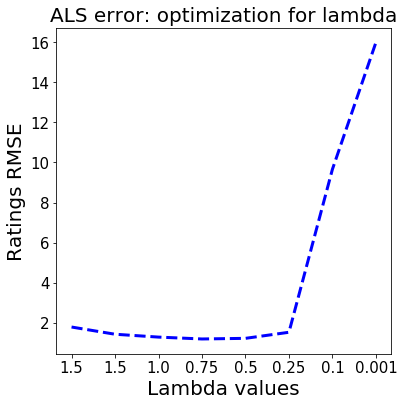

In [263]:
fig, ax = plt.subplots(figsize = (6,6))
labels = [1.5,1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.001, 0.0001]

x_pos = list(range(1,2*len(lambdas),2))
color = ['#FF6666', '#FFB266', '#FFFF66','#B266FF']

plt.plot(x_pos,errors_lambda, linewidth = 3, color = 'blue', linestyle = '--')

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.tick_params(labelsize=15)
plt.xlabel('Lambda values', fontsize = 20)
plt.ylabel('Ratings RMSE', fontsize = 20)
plt.title('ALS error: optimization for lambda', fontsize = 20)
plt.savefig('optimization for lambda.png')
plt.show()

In [30]:
#Implement  ALS model from MLlib: Optimizing the number of iterations
seed = 42
iterations = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
regularization_parameter = 0.5
ranks = 10
errors_iteration = []
err = 0

min_error = float('inf')
best_rank = -1
best_iteration = -1

t0 = time()

for iteration in iterations:
    model = ALS.train(training_RDD, rank, seed=seed, iterations=iteration,
                      lambda_=regularization_parameter)
    predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    errors_iteration.append(error)
    err += 1
    print 'For %s iterations the RMSE is %s' % (iteration, error)
    if error < min_error:
        min_error = error
        best_iteration = iteration
        
print 'The best model was trained %s interations' % best_iteration
print "The total elapsed time was %s min" % round(tt/60,2)

For 2 iterations the RMSE is 3.87303790222
For 4 iterations the RMSE is 1.95939926278
For 6 iterations the RMSE is 1.29212928478
For 8 iterations the RMSE is 1.21532353379
For 10 iterations the RMSE is 1.19918321508
For 12 iterations the RMSE is 1.19382397381
For 14 iterations the RMSE is 1.19158192249
For 16 iterations the RMSE is 1.19050019366
For 18 iterations the RMSE is 1.18991930842
For 20 iterations the RMSE is 1.18957818866
The best model was trained 20 interations
The total elapsed time was 5.45 min


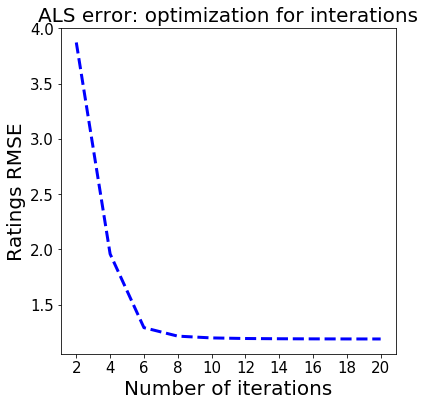

In [265]:
fig, ax = plt.subplots(figsize = (6,6))
labels = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

x_pos = list(range(1,2*len(labels),2))
color = ['#FF6666', '#FFB266', '#FFFF66','#B266FF']

plt.plot(x_pos,errors_iteration, linewidth = 3, color = 'blue', linestyle = '--')

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.tick_params(labelsize=15)
plt.xlabel('Number of iterations', fontsize = 20)
plt.ylabel('Ratings RMSE', fontsize = 20)
plt.title('ALS error: optimization for interations', fontsize = 20)
plt.savefig('optimization for iterations.png')

plt.show()

* The RMSE doesn't seem to significantly decrease after 8 iterations. Hence, I'll take 8 as the optimal number of iterations.

In [252]:
#Implement  ALS model from MLlib: Optimizing the number of ranks
seed = 42
iterations = 8
regularization_parameter = 0.5
ranks = [4, 8, 10, 25, 50]
errors_rank = []

min_error = float('inf')
best_rank = -1

t0 = time()

for rank in ranks:
    model = ALS.train(training_RDD, rank, seed=seed, iterations=iterations,
                      lambda_=regularization_parameter)
    predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    errors_rank.append(error)

    print 'For rank %s the RMSE is %s' % (rank, error)
    if error < min_error:
        min_error = error
        best_rank = rank

tt = time() - t0

print 'The best model was trained with rank %s' % best_rank
print "The total elapsed time was %s min" % round(tt/60,2)

For rank 4 the RMSE is 1.21554120288
For rank 8 the RMSE is 1.21134167436
For rank 10 the RMSE is 1.21532353379
For rank 25 the RMSE is 1.21200920604
For rank 50 the RMSE is 1.21127324283
The best model was trained with rank 50
The total elapsed time was 4.33 min


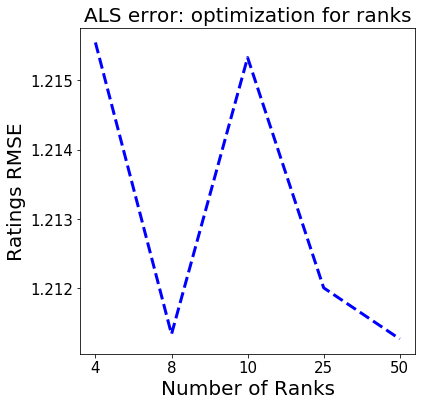

In [266]:
fig, ax = plt.subplots(figsize = (6,6))
labels = [4, 8, 10, 25, 50]

x_pos = list(range(1,2*len(labels),2))
color = ['#FF6666', '#FFB266', '#FFFF66','#B266FF']

plt.plot(x_pos,errors_rank, linewidth = 3, color = 'blue', linestyle = '--')

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.tick_params(labelsize=15)
plt.xlabel('Number of Ranks', fontsize = 20)
plt.ylabel('Ratings RMSE', fontsize = 20)
plt.title('ALS error: optimization for ranks', fontsize = 20)
plt.savefig('optimization for ranks.png')

plt.show()

* The RMSE value doesn't seem to differ too much when using 8 or 50 ranks. Therefore, I will take 8 as the optimal number of ranks.

## The best parameters resulted to be: 
    Ranks = 8
    iterations = 8
    regulariztion parameter = 0.5

In some of the following calculations, I will use the following user-defined functions to calculate user and movie specific biases. This functions requiere the data frame with the ratings to be grouped by "user id" or "movie id"

In [6]:
overall_mean = np.mean(df_data['Rating'].values)
rating_by_user = df_data.groupby('User ID').mean()
rating_by_movie = df_data.groupby('Movie ID').mean()

def user_bias(user_id):
    user_id = int(user_id)
    bias = rating_by_user.loc[user_id,'Rating'] - overall_mean
    return bias

def movie_bias(movie_id):
    movie_id = int(movie_id)
    bias = rating_by_movie.loc[movie_id,'Rating'] - overall_mean
    return bias

In [10]:
training_RDD.take(3)


[(u'1789934', u'9886', 4.000000),
 (u'2400047', u'12074', 3.000000),
 (u'1986551', u'299', 1.000000)]

After I determined the optimal hyperparameters, I realized that the predicted ratings contained values higher than 5 and lower than 1. That is, ratings that are lower than 1 Stars or higher than 5 Stars, which arethe limits of the netflix rating scale.To account for that, i wrote the following function to set any ratings higher than 5 to 5 and any ratings lower than 1 to 1.

In [7]:
def adjust_rating(x):
    if x<1:
        result = 1
    elif x>5:
        result = 5
    else:
        result = x
    return result

Next, I proceed to implement the ALS model using the optimal hyperparameters

In [8]:
#Implement  ALS model from MLlib with optimal hyperparameters
seed = 42
iterations = 8
regularization_parameter = 0.5
rank = 8
errors = []

t0 = time()

model = ALS.train(training_RDD, rank, seed=seed, iterations=iterations,lambda_=regularization_parameter)

predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))

rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
rates_and_preds = rates_and_preds.map(lambda x:(x[0],(x[1][0],adjust_rating(x[1][1]))))

tt = time() - t0

print "The total elapsed time was %s min" % round(tt/60,2)

The total elapsed time was 0.49 min


In [42]:
#Next, I proceeed to adjust the rating predictions based on the specific user and movie biases

rates_and_preds_user_adj = rates_and_preds\
.map(lambda x: ((x[0][0],x[0][1]),(x[1][0],x[1][0]+user_bias(x[0][0]))))\
.map(lambda x:(x[0],(x[1][0],adjust_rating(x[1][1]))))

rates_and_preds_movie_adj = rates_and_preds\
.map(lambda x: ((x[0][0],x[0][1]),(x[1][0],x[1][0]+movie_bias(x[0][1]))))\
.map(lambda x:(x[0],(x[1][0],adjust_rating(x[1][1]))))

rates_and_preds_adj = rates_and_preds\
.map(lambda x: ((x[0][0],x[0][1]),(x[1][0],x[1][0]+user_bias(x[0][0])+movie_bias(x[0][1]))))\
.map(lambda x:(x[0],(x[1][0],adjust_rating(x[1][1]))))

The format of the elements in the ratings and predictions RDDs is the following:
    ((User ID, Movie ID),(Actual Rating, Predicted Rating))

For example:

In [47]:
print(rates_and_preds.collect()[111])

((1435594, 12694), (3.0, 2.883369650063927))


In [43]:
#And now we calculate the errors for this different predictions. For that we use RMSE.
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
error_user_adj = math.sqrt(rates_and_preds_user_adj.map(lambda r: (r[1][0] - r[1][1])**2).mean())
error_movie_adj = math.sqrt(rates_and_preds_movie_adj.map(lambda r: (r[1][0] - r[1][1])**2).mean())
error_adj = math.sqrt(rates_and_preds_adj.map(lambda r: (r[1][0] - r[1][1])**2).mean())

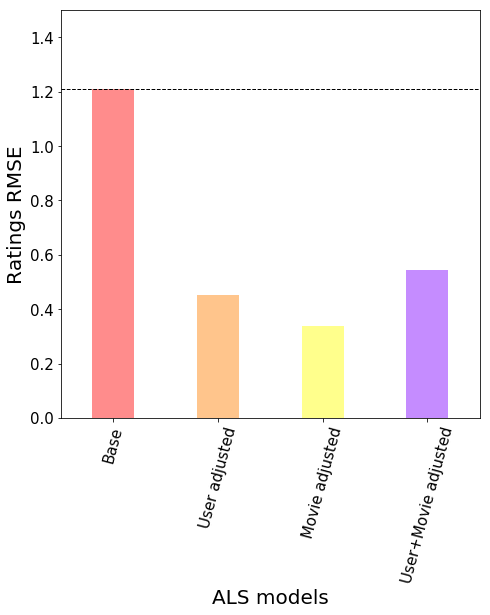

In [269]:
rmses = [error,error_user_adj,error_movie_adj,error_adj]
x_pos = list(range(1,2*len(rmses),2))
color = ['#FF6666', '#FFB266', '#FFFF66','#B266FF']
labels = ['Base', 'User adjusted', 'Movie adjusted', 'User+Movie adjusted']

fig, ax = plt.subplots(figsize = (7.5, 7.5))

plt.plot([0,14],[error]*2, linewidth = 1, color = 'k', linestyle = '--')
plt.bar(x_pos,
        # using the data from the mean_values
        rmses, 
        # aligned in the center
        align='center',
        # with color
        color = color,
        # transparency
        alpha=.75)

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
plt.xlim(0,8)
plt.ylim(0,1.5)
plt.xticks(rotation=75)
plt.xlabel('ALS models', fontsize = 20)
plt.ylabel('Ratings RMSE', fontsize = 20)
ax.tick_params(labelsize=15)
plt.savefig('ALS_RMSEs.png', bbox_inches="tight")
plt.show()

We can see from the plot shown above that we obtain a lower error in ratings prediction, when we adjust the predictions from our ALS model using the user and movie specific rating bias alone. Hence, for generating movie predictions I will only take into account the movie-specific bias.

To make recomendations, we can start with a list of movie ratings for a new user (not included in the original dataset). For example:

In [9]:
#New user ("0"), list of movie ratings

new_ratings = [
    (0,14941,4),# The Matrix
    (0,14928,4),# Dead Poets Society
    (0,5344,5),# Fullmetal Alchemist
    (0,10463,4),# Pokemon: The First Movie
    (0,10453,4),# Pokemon Advanced
    (0,5732,4),# Good Will Hunting
    (0,15096,5),# The Notebook
    (0,17132,5),# Waking Life
    (0,11763,3),# Serendipity
    (0,178,5) #A Beautiful Mind
]

Next, we have to incroporate those ratings to our datasets and retrain our model:

In [10]:
new_user_ratings_RDD = sc.parallelize(new_ratings)
print 'New user ratings: %s' % new_user_ratings_RDD.collect()
ratings_updated = ratings.union(new_user_ratings_RDD)

#I will also update the dataframe i use to calculate the biases
c = 0
for elem in new_ratings:
    x,y,z=elem
    df_data.loc[999999+c] = [x,z,np.nan,y,np.nan,np.nan,np.nan,np.nan,np.nan]
    c += 1

overall_mean = np.mean(df_data['Rating'].values)
rating_by_movie = df_data.groupby('Movie ID').mean()


def ratings_count(x):
    count = np.sum(df_data['Movie ID'] == x)
    return count

New user ratings: [(0, 14941, 4), (0, 14928, 4), (0, 5344, 5), (0, 10463, 4), (0, 10453, 4), (0, 5732, 4), (0, 15096, 5), (0, 17132, 5), (0, 11763, 3), (0, 178, 5)]


In [11]:
#Now we can proceed to train the new model with the updated set of ratings:
seed = 42
iterations = 8
regularization_parameter = 0.5
rank = 8

t0 = time()
model_updated = ALS.train(ratings_updated, rank, seed=seed, iterations=iterations,lambda_=regularization_parameter)
tt = time() - t0

print "The total elapsed time to train the new model was %s min" % round(tt/60,2)

The total elapsed time to train the new model was 0.4 min


In [12]:
#To make and show recomendations for the new user, I used the following two functions

def make_predictions(new_ratings,data_frame):
    ## This function creates a list of movie predictions
    
    #new_ratings: the list of predicted movie ratings for the new user
     
    user_id,movie_id,rating = zip(*new_ratings)
    list_of_users = list(set(data_frame['User ID'].values))
    list_of_movies = list(set(data_frame['Movie ID'].values))
    movies_to_predict = [x for x in list_of_movies if x not in movie_id]
    to_predict = zip([0]*len(movies_to_predict),movies_to_predict)
    to_predict = sc.parallelize(to_predict)
    
    #Predictions of the updated model
    predictions_adj = model_updated.predictAll(to_predict).map(lambda x: ((x[0], x[1]), x[2]))\
    .map(lambda x: (x[0],x[1]+movie_bias(x[0][1])))\
    .map(lambda x: (x[0],adjust_rating(x[1])))
    
    #Return the predicted ratings
    user_movie_id,rating = zip(*predictions_adj.collect())
    
    return user_movie_id, rating

def get_top_ratings(min_rating,min_review,number_to_show,user_movie_id, rating):
    ## This function prints the 
    #min_rating: minimum rating for a movie to be recomended
    #min_reviews: minimum number of reviews for a movie to be recomended
    #number_to_show: number of recomendations to show
    #user_movie_id: list of (user_id,movie_id) tuples
    #rating: list of ratings
    
    movie_r = []
    ratings_r =[]
    for i in range(len(rating)):
        if rating[i] >= min_rating and np.sum(df_data['Movie ID'] == user_movie_id[i][1]) >= min_review:
            movie_r.append(user_movie_id[i][1])
            ratings_r.append(rating[i])
    
    to_show = np.random.choice(len(ratings_r), number_to_show, replace = False).tolist()
    for i in to_show:
        print  "%s. Predicted rating: %s Stars" % (df_movies.loc[movie_r[i],'Name'],ratings_r[i])
    
    return movie_r, ratings_r

Now we can use our updated model to make predictions for the new user. I will consider that any movie with a rating of 4.5 Stars or more should be recomended to the user. Here, we will print a sample of 20 recomended movies, with a rating of at least 4.5 Stars and a minimum number of reviews of 20.

In [13]:
t0 = time()

print("Sample list of recomended movies: ")
print(" ")
user_movie_id, rating = make_predictions(new_ratings,df_data)
movie_r, ratings_r = get_top_ratings(4.5,20,20,user_movie_id, rating)

tt = time() - t0
print(" ")
print "Total number of recomended movies: %s" % len(ratings_r)
print "Elapsed time: %s min" % round(tt/60,2)

Sample list of recomended movies: 
 
The Work of Director Spike Jonze. Predicted rating: 4.71139164804 Stars
The Princess Bride. Predicted rating: 4.76002170012 Stars
Finding Nemo (Full-screen). Predicted rating: 4.9641359762 Stars
Gone with the Wind: Collector's Edition. Predicted rating: 4.60965018893 Stars
Rear Window. Predicted rating: 4.79500050874 Stars
As Time Goes By: Series 4. Predicted rating: 4.80972476584 Stars
Million Dollar Baby. Predicted rating: 4.64580944925 Stars
Bill Cosby: Himself. Predicted rating: 4.66366787817 Stars
Best of The Muppet Show: Peter Sellers / John Cleese / Dudley Moore. Predicted rating: 4.56483548539 Stars
South Park: Season 3. Predicted rating: 4.53111310575 Stars
Star Wars: Episode V: The Empire Strikes Back. Predicted rating: 5 Stars
Dr. Strangelove. Predicted rating: 4.54194588459 Stars
Something the Lord Made. Predicted rating: 4.93464786053 Stars
Buffy the Vampire Slayer: Season 2. Predicted rating: 5 Stars
The Sixth Sense. Predicted rating: 

From this sample of recomended movies, out of a total of 419 recomendations for the new user, we can see that there is some consistency in the type of movies being recomended, with respect to the original list of ratings for the new user. For example, if you liked "The Matrix" you might be likely to also like "Lord of the rings", or if you liked "A Beautiful mind" and "Good Will Hunting" you might be likely to also like "Forrest Gump".


# 5. How general are the results previously shown ?.

Given that the ALS model is being constructed with only a subset of the original ratings, one could ask how general are the results that were just described. To answer this, I created 10 random samples from the original DataSet, each containing 1 million ratings. For each of this samples an ALS model was created, and also calculated the respective errors.

In [14]:
names = ['split1','split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10']

In [13]:

all_global_means = []
all_errors = []
times =[]

for i in range(len(names)):
    t0 = time()

    df = pd.read_csv(names[i]+'.csv')
    rating_by_movie = df.groupby('Movie ID').mean()
    rating_by_user = df.groupby('User ID').mean()
    overall_mean = np.mean(df['Rating'].values)
    
    all_global_means.append(overall_mean)
    
    df_rdd = spark.read.csv(names[i]+'.csv', header = True)
    X=df_rdd.select(df_rdd['User ID'],df_rdd['Movie ID'],df_rdd['Rating'].cast("float"))
    ratings_rdd_2 = X.rdd
    
    #Here I'm splitting the data into training and test set
    ratings = ratings_rdd_2.map(lambda x: (x[0],x[1],x[2]))
    training_RDD, test_RDD = ratings.randomSplit([7,3], seed = 42)
    test_for_predict_RDD = test_RDD.map(lambda x: (x[0],x[1]))
    ratings.cache()
    training_RDD.cache()
    test_RDD.cache()
    test_for_predict_RDD.cache()
    
    #Implement  ALS model from MLlib with optimal hyperparameters
    seed = 42
    iterations = 8
    regularization_parameter = 0.5
    rank = 8
    errors = []
    
    model = ALS.train(training_RDD, rank, seed=seed, iterations=iterations,lambda_=regularization_parameter)
    predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    rates_and_preds = rates_and_preds.map(lambda x:(x[0],(x[1][0],adjust_rating(x[1][1]))))
        
    #Next, I proceeed to adjust the rating predictions based on the specific user and movie biases
    rates_and_preds_user_adj = rates_and_preds\
    .map(lambda x: ((x[0][0],x[0][1]),(x[1][0],x[1][0]+user_bias(x[0][0]))))\
    .map(lambda x:(x[0],(x[1][0],adjust_rating(x[1][1]))))
    
    rates_and_preds_movie_adj = rates_and_preds\
    .map(lambda x: ((x[0][0],x[0][1]),(x[1][0],x[1][0]+movie_bias(x[0][1]))))\
    .map(lambda x:(x[0],(x[1][0],adjust_rating(x[1][1]))))
    
    rates_and_preds_adj = rates_and_preds\
    .map(lambda x: ((x[0][0],x[0][1]),(x[1][0],x[1][0]+user_bias(x[0][0])+movie_bias(x[0][1]))))\
    .map(lambda x:(x[0],(x[1][0],adjust_rating(x[1][1]))))
    
    #And now we calculate the errors for this different predictions. For that we use RMSE.
    error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    error_user_adj = math.sqrt(rates_and_preds_user_adj.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    error_movie_adj = math.sqrt(rates_and_preds_movie_adj.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    error_adj = math.sqrt(rates_and_preds_adj.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
    all_errors.append((error,error_user_adj,error_movie_adj,error_adj))
        
    tt = time() - t0
    times.append(tt)
    
    print "The total elapsed time was %s min" % round(tt/60,2)
  

The total elapsed time was 3.49 min
The total elapsed time was 3.48 min
The total elapsed time was 3.5 min
The total elapsed time was 3.55 min
The total elapsed time was 4.17 min
The total elapsed time was 3.58 min
The total elapsed time was 3.48 min
The total elapsed time was 3.53 min
The total elapsed time was 4.01 min
The total elapsed time was 4.56 min


In [19]:
base = [x[0] for x in all_errors]
user_adj = [x[1] for x in all_errors]
movie_adj = [x[2] for x in all_errors]
adj = [x[3] for x in all_errors]

In [28]:
data = [base, user_adj, movie_adj, adj]

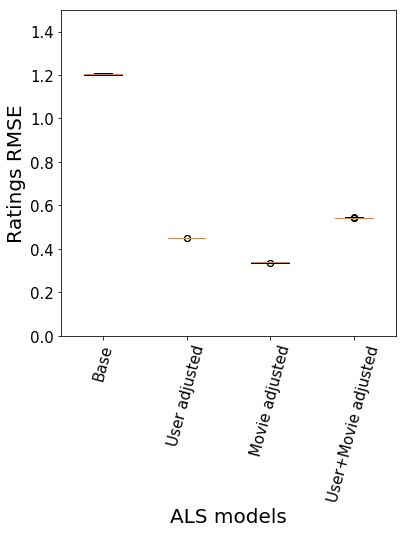

In [42]:
labels = ['Base', 'User adjusted', 'Movie adjusted', 'User+Movie adjusted']

fig, ax = plt.subplots(figsize = (6,6))
plt.boxplot(rmses)
ax.set_xticklabels(labels)
plt.xticks(rotation=75)
plt.xlabel('ALS models', fontsize = 20)
plt.ylabel('Ratings RMSE', fontsize = 20)
plt.ylim(0,1.5)
ax.tick_params(labelsize=15)
plt.savefig('ALS_RMSEs_boxplot.png', bbox_inches="tight")
plt.show()

As expected, the implementation of the ALS model give similar error values for 10 random samples that are just analyzed. This is evidence by the very small (almost non-existent) spread of values in the boxplot above

Next, we will take one of the random  sub-sample data sets that we just used, and use it to make some recomendations. We will use the same list of new ratings that we used before.

In [49]:
np.random.choice(names,1).tolist()[0]

'split5'

In [15]:
t0 = time()

#Here Im picking at random one of the original 10 samples from before, and creating the respectives dataframe 
# and RDDs 

name = np.random.choice(names,1).tolist()
df = pd.read_csv(name[0]+'.csv')
del df['Unnamed: 0']
c = 0
for elem in new_ratings:
    x,y,z=elem
    df.loc[999999+c] = [x,z,np.nan,y,np.nan,np.nan]
    c += 1

overall_mean = np.mean(df['Rating'].values)
rating_by_movie = df.groupby('Movie ID').mean()
    
df_rdd = spark.read.csv(name[0]+'.csv', header = True)
X=df_rdd.select(df_rdd['User ID'],df_rdd['Movie ID'],df_rdd['Rating'].cast("float"))
ratings_rdd_2 = X.rdd
new_ratings_RDD = sc.parallelize(new_ratings)
ratings_updated = ratings.union(new_user_ratings_RDD)

#Now we can proceed to train the new model with the updated set of ratings:
seed = 42
iterations = 8
regularization_parameter = 0.5
rank = 8

t0 = time()
model_updated = ALS.train(ratings_updated, rank, seed=seed, iterations=iterations,lambda_=regularization_parameter)
tt = time() - t0

print "The total elapsed time to train the new model was %s min" % round(tt/60,2)

#Finally, we can see which recomendationds we get.
#As before, for a movie to be recomended, it should have at least 4.5 Stars as a predicted rating,
# and at least 20 ratings.
t0 = time()

print("Sample list of recomended movies: ")
print(" ")
user_movie_id, rating = make_predictions(new_ratings,df)
movie_r2, ratings_r2 = get_top_ratings(5,20,20,user_movie_id, rating)

tt = time() - t0
print(" ")
print "Total number of recomended movies: %s" % len(ratings_r)
print "Elapsed time: %s min" % round(tt/60,2)

The total elapsed time to train the new model was 0.27 min
Sample list of recomended movies: 
 
Finding Nemo (Widescreen). Predicted rating: 5 Stars
Lord of the Rings: The Return of the King. Predicted rating: 5 Stars
Star Wars: Episode VI: Return of the Jedi. Predicted rating: 5 Stars
As Time Goes By: Series 4. Predicted rating: 5 Stars
Buffy the Vampire Slayer: Season 7. Predicted rating: 5 Stars
Red Dwarf: Series 4. Predicted rating: 5 Stars
Homicide: Life on the Street: Season 4. Predicted rating: 5 Stars
The Godfather. Predicted rating: 5 Stars
Gilmore Girls: Season 3. Predicted rating: 5 Stars
South Park: Season 5. Predicted rating: 5 Stars
The Sopranos: Season 1. Predicted rating: 5 Stars
CSI: Season 4. Predicted rating: 5 Stars
Gladiator: Extended Edition. Predicted rating: 5 Stars
Seinfeld: Season 4. Predicted rating: 5 Stars
Farscape: The Peacekeeper Wars. Predicted rating: 5 Stars
Tokyo Story. Predicted rating: 5 Stars
Seinfeld: Season 3. Predicted rating: 5 Stars
Law & Orde

 We can see that in both our first and second ALS models, we have a total of 419 movies being recomended, when we consider movies with a 5 Star predicted rating and at least

In [16]:
s1 = set(movie_r)
s2 = set(movie_r2)
inter = s1.intersection(s2)
s = float(len(inter))*100/101
print "Percentage of common recomended movies: %s" % round(s,2)


Percentage of common recomended movies: 82.18


Doing a quick calculation shows there is a 82% overlap in between the movies recomended by the first and second models

# 6. Can we obtain similar results/performance by using Singular Value Decomposition (SVD) ?

Many other methods can be used to estimate the predicted tating for a specific movie. In Singular Value Decomposition (SVD), for example, we start with a sparse matrix R, containing the available ratings for each movie/user pair. The matrix R can be decomposed  into two unitary matrices, U and V, and a diagonal matrix D, such that R = UDV'. In a general sense, U represents how much users “like” each feature and V' represents how relevant each feature is to each movie. By taking the top k features (rows) of U and V, one can calculate a lower rank aproximation of the original matrix, which is then used for making predictions of movie ratings.

source: https://beckernick.github.io/matrix-factorization-recommender/

Conviniently, 'Surprise' a python sci-kit for recomender systems, allows to easily implement SVD.

source: http://surpriselib.com/

In [1]:
# First we will import the necessary functions
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy

from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [5]:
#We will use on of the random samples that we used before for ALS
df = pd.read_csv('/Users/saverm/Desktop/springboard/capstone 1/final report/untitled folder 2/test.csv')
df.head()

,User ID,Movie ID,Rating
0,886454,11837,3
1,1457260,873,5
2,922812,3927,5
3,1582635,7745,4
4,1366670,14727,4


In [6]:
#And here we load a dataframe containing the movie IDs and Titles information
df_movies = pd.read_csv('/Users/saverm/Desktop/springboard/capstone 1/final report/movies_plus_genre_info_2.csv')
df_movies.head()

,Name,Year,Genres,Sci-Fi,Crime,Romance,Animation,Music,Comedy,War,...,Action,Documentary,Musical,History,Family,Reality-TV,Fantasy,Game-Show,Sport,Biography
0,Dinosaur Planet,2003,"Documentary, Animation, Family",N,N,N,Y,N,N,N,...,N,Y,N,N,Y,N,N,N,N,N
1,Isle of Man TT 2004 Review,2004,None,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
2,Character,1997,"Crime, Drama, Mystery",N,Y,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
3,Paula Abdul's Get Up & Dance,1994,None,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
4,The Rise and Fall of ECW,2004,None,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N


In [115]:
#Before implementing an SVD model, we need to put the data in the right format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['User ID', 'Movie ID', 'Rating']], reader)

In [117]:
# sample random trainset and testset
# test set is made of 30% of the ratings.
trainset, testset = train_test_split(data, test_size=.3)

In [119]:
# We'll use the famous SVD algorithm.
model = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
model.fit(trainset)
predictions = model.test(testset)

In [125]:
# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0007


1.000703

Note that the RMSE is ~ 1, which is slightly better than the RMSE (~1.2), without bias adjustments, obtained  in the ALS model we implemented before.

In [150]:
#Using the predictions that we obtained, we create a data frame
df4 = pd.DataFrame(predictions)
df4.columns = ['User ID', 'Movie ID', 'Actual Rating', 'Predcited Rating', 'aux']
del df4['aux']
df4.head()

,User ID,Movie ID,Actual Rating,Predcited Rating
0,1086329,11149,3,3.456652
1,2532803,1800,5,4.113506
2,2106821,6287,3,3.910562
3,2060522,14725,4,3.447755
4,11144,10094,3,3.572711


In [151]:
#Here we group the data and define some functions to calculate the biases
overall_mean = np.mean(df4['Actual Rating'].values)
rating_by_user = df4.groupby('User ID').mean()
rating_by_movie = df4.groupby('Movie ID').mean()

def user_bias(user_id):
    user_id = int(user_id)
    bias = rating_by_user.loc[user_id,'Actual Rating'] - overall_mean
    return bias

def movie_bias(movie_id):
    movie_id = int(movie_id)
    bias = rating_by_movie.loc[movie_id,'Actual Rating'] - overall_mean
    return bias

In [180]:
#Now, we proceed to add the user and movie specific biases to the predicted ratings.
#In case that the adjusted rating is higher than 5, it will be set to 5.
#In case that the adjusted rating is lower than 1, it will be set to 1.

def with_user_bias(row):
    a = row['Actual Rating'] + user_bias(row['User ID'])
    if a > 5:
        a = 5
    elif a < 1:
        a = 1
        
    return a

def with_movie_bias(row):
    a = row['Actual Rating'] + movie_bias(row['Movie ID'])
    if a > 5:
        a = 5
    elif a < 1:
        a = 1
        
    return a

def all_bias(row):
    a = row['Actual Rating'] + user_bias(row['User ID']) + movie_bias(row['Movie ID'])
    if a > 5:
        a = 5
    elif a < 1:
        a = 1
        
    return a

df4['with_user_bias'] = df4.apply(with_user_bias, axis=1)
df4['with_movie_bias'] = df4.apply(with_movie_bias, axis=1)
df4['with_all_bias'] = df4.apply(all_bias, axis=1)

df4.head()

,User ID,Movie ID,Actual Rating,Predcited Rating,with_user_bias,with_movie_bias,with_all_bias
0,1086329,11149,3,3.456652,2.395737,2.599345,1.995082
1,2532803,1800,5,4.113506,5.000000,5.000000,5.000000
2,2106821,6287,3,3.910562,2.395737,3.337617,2.733354
3,2060522,14725,4,3.447755,4.395737,3.800231,4.195968
4,11144,10094,3,3.572711,3.062403,3.020737,3.083140


In [181]:
#After these adjustments, we calculate and plot the respective errors, measured as RMSE
rmse = np.sqrt(mean_squared_error(df5['Actual Rating'].values, df4['Predcited Rating'].values))
rmse_user_adj = np.sqrt(mean_squared_error(df5['Actual Rating'].values, df4['with_user_bias'].values))
rmse_movie_adj = np.sqrt(mean_squared_error(df5['Actual Rating'].values, df4['with_movie_bias'].values))
rmse_adj = np.sqrt(mean_squared_error(df5['Actual Rating'].values, df4['with_all_bias'].values))

print rmse
print rmse_user_adj
print rmse_movie_adj
print rmse_adj

1.000702585324963
0.8604173370876813
0.45467698747851926
1.0908888927374834


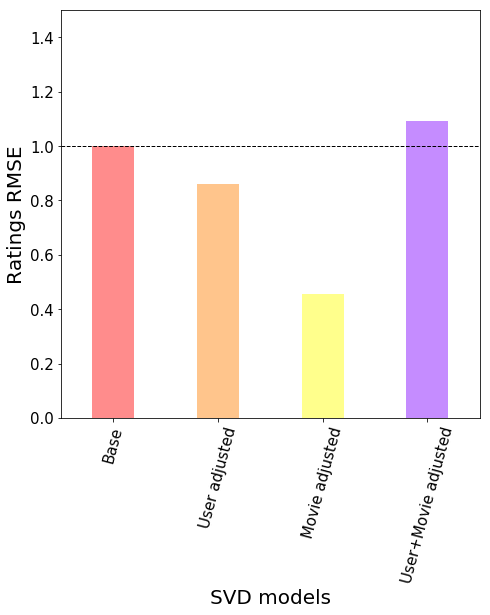

In [179]:
#Here we plot the RMSEs we obtained

rmses = [rmse,rmse_user_adj,rmse_movie_adj,rmse_adj]
x_pos = list(range(1,2*len(rmses),2))
color = ['#FF6666', '#FFB266', '#FFFF66','#B266FF']
labels = ['Base', 'User adjusted', 'Movie adjusted', 'User+Movie adjusted']

fig, ax = plt.subplots(figsize = (7.5, 7.5))

plt.plot([0,14],[rmse]*2, linewidth = 1, color = 'k', linestyle = '--')
plt.bar(x_pos,
        # using the data from the mean_values
        rmses, 
        # aligned in the center
        align='center',
        # with color
        color = color,
        # transparency
        alpha=.75)

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
plt.xlim(0,8)
plt.ylim(0,1.5)
plt.xticks(rotation=75)
plt.xlabel('SVD models', fontsize = 20)
plt.ylabel('Ratings RMSE', fontsize = 20)
ax.tick_params(labelsize=15)
plt.savefig('SVD_RMSEs.png', bbox_inches="tight")
plt.show()

Similar to the results we obtained for the ALS based recomender from before, adjusting the predicted ratings from the SVD based recomender with a movie-specific rating bias greatly inproves the prediction accuracy.

In [7]:
#Like before we will include the following list of movies for a new user, 
#not previously present in the original dataset

#New user ("0"), list of movie ratings

new_ratings = [
    (0,14941,4),# The Matrix
    (0,14928,4),# Dead Poets Society
    (0,5344,5),# Fullmetal Alchemist
    (0,10463,4),# Pokemon: The First Movie
    (0,10453,4),# Pokemon Advanced
    (0,5732,4),# Good Will Hunting
    (0,15096,5),# The Notebook
    (0,17132,5),# Waking Life
    (0,11763,3),# Serendipity
    (0,178,5) #A Beautiful Mind
]


df6 = pd.DataFrame(new_ratings)
df6.columns = ['User ID', 'Movie ID', 'Rating']

new_df = pd.concat([df, df6])

new_df.tail()

,User ID,Movie ID,Rating
5,0,5732,4
6,0,15096,5
7,0,17132,5
8,0,11763,3
9,0,178,5


In [8]:
#Wwe out the new data set into the right format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df[['User ID', 'Movie ID', 'Rating']], reader)

In [9]:
#We proceed to create a SVD model and validate it using a 5-fold crossvalidation
new_model = SVD()
cross_validate(new_model, data, measures = ['RMSE'], cv = 5, verbose = True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9974  0.9962  1.0004  0.9994  0.9993  0.9985  0.0015  
Fit time          57.85   58.91   59.68   57.46   55.27   57.83   1.50    
Test time         2.31    2.30    2.31    2.55    2.06    2.31    0.16    


{u'fit_time': (57.851417, 58.905262, 59.676914, 57.463631, 55.268698),
 u'test_rmse': array([0.99742219, 0.99619159, 1.00040848, 0.99942086, 0.99925657]),
 u'test_time': (2.310477, 2.301514, 2.306180, 2.554548, 2.059693)}

We can see that the prediction error, measured as RMSE, remains stable across the different folds of the data

In [10]:
#Now We proceed to train our SVD model
trainset = data.build_full_trainset()
new_model.fit(trainset)

In [11]:
#Before making recomendations, we need a list of all the movies the new user has not yet rated
all_ids = list(set(df['Movie ID'].values.tolist()))
new_ids = [14941, 14928, 5344, 10463, 10453, 5732, 15096, 17132, 11763, 178]
not_rated_ids = [x for x in all_ids if x not in new_ids]
pred_rating = []

In [12]:
#Here we predict the raings for the movies that the new user 
#We also group the data (in the new_df data frame)by movie ID and define the 
#movie_bias function needed to calculate the movie-specific bias

overall_mean = np.mean(new_df['Rating'].values)
rating_by_movie = new_df.groupby('Movie ID').mean()

def movie_bias(movie_id):
    movie_id = int(movie_id)
    bias = rating_by_movie.loc[movie_id,'Rating'] - overall_mean
    return bias

pred_rating = []
for idx in not_rated_ids:
    pred = new_model.predict(0, idx)
    pred_rating.append(pred[3] + movie_bias(idx))  

In [24]:
# A movie will be cosidered for recomendation if it has at least 20 ratings in the dataset used to train the SVD model

def adjust(r):
    a = r
    if a > 5:
        a = 5
    elif a < 1:
        a = 1
    
    return a

print('Recomended movies for new user:')

L = zip(not_rated_ids,pred_rating)
Ls = sorted(L, key=lambda x: x[1])
Ls.reverse()
top,ratings = zip(*Ls)
ratings = map(adjust,ratings)
c = 0
i = 0

print(' ')
while c < 25:
    if np.sum(new_df['Movie ID'] == top[i]) > 20:
        print  "%s. Predicted rating: %s Stars" % (df_movies.loc[top[i]-1,'Name'],ratings[i])
        c += 1
        i += 1
    else:
        i += 1


Recomended movies for new user:
 
Dead Like Me: Season 2. Predicted rating: 5 Stars
Lost: Season 1. Predicted rating: 5 Stars
Lord of the Rings: The Return of the King: Extended Edition. Predicted rating: 5 Stars
The Lord of the Rings: The Fellowship of the Ring: Extended Edition. Predicted rating: 5 Stars
Seinfeld: Season 3. Predicted rating: 5 Stars
Lord of the Rings: The Two Towers: Extended Edition. Predicted rating: 5 Stars
Angel: Season 5. Predicted rating: 5 Stars
The Simpsons: Season 6. Predicted rating: 5 Stars
The Shawshank Redemption: Special Edition. Predicted rating: 5 Stars
Firefly. Predicted rating: 5 Stars
Cinderella: Special Edition. Predicted rating: 5 Stars
Family Guy: Vol. 1: Seasons 1-2. Predicted rating: 5 Stars
Nip/Tuck: Season 2. Predicted rating: 5 Stars
Raiders of the Lost Ark. Predicted rating: 5 Stars
Anne of Green Gables. Predicted rating: 5 Stars
Gladiator: Extended Edition. Predicted rating: 5 Stars
The Twilight Zone: Vol. 42. Predicted rating: 5 Stars
Fa

For comparson here is the list of top recomended movies for the same new user (user ID = 0),
that we obtained from the ALS based recomender

Finding Nemo (Widescreen). Predicted rating: 5 Stars <br>
Lord of the Rings: The Return of the King. Predicted rating: 5 Stars<br>
Star Wars: Episode VI: Return of the Jedi. Predicted rating: 5 Stars<br>
As Time Goes By: Series 4. Predicted rating: 5 Stars<br>
Buffy the Vampire Slayer: Season 7. Predicted rating: 5 Stars<br>
Red Dwarf: Series 4. Predicted rating: 5 Stars<br>
Homicide: Life on the Street: Season 4. Predicted rating: 5 Stars<br>
The Godfather. Predicted rating: 5 Stars<br>
Gilmore Girls: Season 3. Predicted rating: 5 Stars<br>
South Park: Season 5. Predicted rating: 5 Stars<br>
The Sopranos: Season 1. Predicted rating: 5 Stars<br>
CSI: Season 4. Predicted rating: 5 Stars<br>
Gladiator: Extended Edition. Predicted rating: 5 Stars<br>
Seinfeld: Season 4. Predicted rating: 5 Stars<br>
Farscape: The Peacekeeper Wars. Predicted rating: 5 Stars<br>
Tokyo Story. Predicted rating: 5 Stars<br>
Seinfeld: Season 3. Predicted rating: 5 Stars<br>
Law & Order: Season 3. Predicted rating: 5 Stars<br>
CSI: Season 3. Predicted rating: 5 Stars<br>
The Simpsons: Bart Wars. Predicted rating: 5 Stars

Doing a quick overview of these two lists we see that both the ALS and SVD base recomenders give similar results for the same new user. For example, in both cases we see recomendations such as "The Lord of the Rings" or "The Simpsons". Of note, this are only the top recomended movies, so more similarities 

# 7. Conclusion and Future directions.


The NetFlix prize competition aimed at improving the accuracy of Netflix recomendation system, called CineMatch. The RMSE for the recomendations produced by this method as ~ 1. Both the ALS (basal RMSE: ~1.2) and SVD (basal RMSE: ~1) produced similar predictions errors. For simplicity, the analysis presented here was performed using only a subset          (1 million) of the ratings in the NetFlix Prize, therefore a higher accuracy (lower prediction error) could be achieved by analysing the entire Netflix Prize data set on a system with higher computing power.

The NetFlix prize competition was won by combining multiple predictive models, with a RMSE of ~0.85. Surprizingly, here we obtained an even better (lower) prediction error (~0.4 RMSE), by simply adjusting the predicted ratings by the overall user or movie specific rating biases. Therefore, it is suggested that future reccomender systems would greatly benefit from incorporating this type of biases in ratings predictions.

Of note, this type of movie recommender systems will most likely need to be revised, as Netflix has changed its 5 Star rating scale to a "Liked" or "Not Liked" system.


# 8. References

"Collaborative Filtering - RDD-based API",
Link: https://spark.apache.org/docs/2.2.0/mllib-collaborative-filtering.html

"An on-line movie recommending service using Spark", 
Link: https://github.com/jadianes/spark-movie-lens/blob/master/notebooks/building-recommender.ipynb

"Surprise: A python scikit for recommender systems",
Link: http://surpriselib.com/

"NetFlix Prize",
Link: https://en.wikipedia.org/wiki/Netflix_Prize

"Winning the Netflix Prize: A Summary", 
Link: http://blog.echen.me/2011/10/24/winning-the-netflix-prize-a-summary/